In [550]:
import pandas as pd
from matplotlib import dates
from tsai.basics import *
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np

# Quick Analysis of the Data Used in the Benchmark

In this notebook, we perform a brief analysis of the data that [Licata et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496) used in their paper benchmarking the SOLAR2000 model. We analyze this data to determine if there are any differences compared to the data we are using to train our model.


In [551]:
config = yaml2dict('./config/base.yaml', attrdict=True)
config

```json
{ 'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 1024,
  'horizon': 6,
  'init_weights': False,
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 5,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

First, let's load the data and identify which values correspond to which variables, as the data is not labeled.

In [552]:
column_names = ['JulianDay', 'Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7', 'Var_8']

df = pd.read_csv('../data/SET_SOLFSMY.TXT', sep='\s+', comment='#', names=column_names, usecols=range(5, 14), dtype={
    'JulianDay': np.float64,
    'Var_1': np.float32,
    'Var_2': np.float32,
    'Var_3': np.float32,
    'Var_4': np.float32,
    'Var_5': np.float32,
    'Var_6': np.float32,
    'Var_7': np.float32,
    'Var_8': np.float32
}) # Range of data of FSMY values

df['Date'] = pd.to_datetime(df['JulianDay'], unit='D', origin='julian')
df = df[df['Date'].dt.time == pd.to_datetime('12:00:00').time()].reset_index(drop=True)

# We are only interested in the data that we will use a test-set
df = df[(df.Date >= config.test_start_datetime) & (df.Date <= config.test_end_datetime)]

df.head()

,JulianDay,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Date
30,2456202.0,113.199997,103.500000,131.899994,119.300003,125.900002,124.400002,128.100006,116.900002,2012-10-01 12:00:00
31,2456203.0,108.000000,103.400002,124.500000,119.199997,117.000000,124.199997,118.199997,116.699997,2012-10-02 12:00:00
32,2456204.0,102.900002,103.300003,120.199997,119.000000,113.400002,124.099998,111.699997,116.400002,2012-10-03 12:00:00
33,2456205.0,98.500000,103.199997,112.699997,118.699997,111.900002,123.900002,109.500000,116.199997,2012-10-04 12:00:00
34,2456206.0,95.500000,103.000000,109.599998,118.400002,106.099998,123.599998,106.199997,116.099998,2012-10-05 12:00:00


In [553]:
df.isna().sum()

JulianDay    0
Var_1        0
Var_2        0
Var_3        0
Var_4        0
Var_5        0
Var_6        0
Var_7        0
Var_8        0
Date         0
dtype: int64

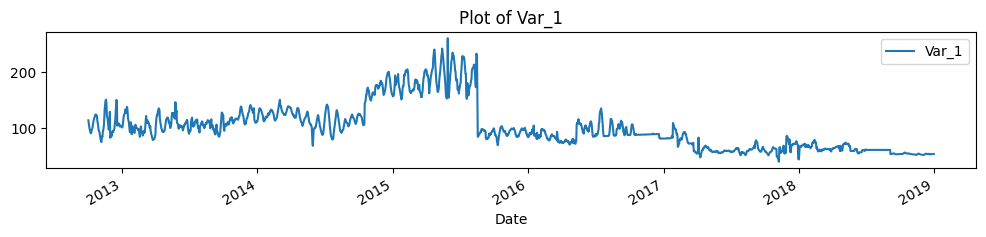

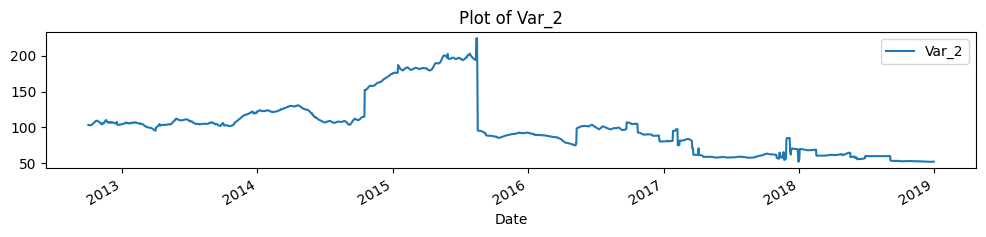

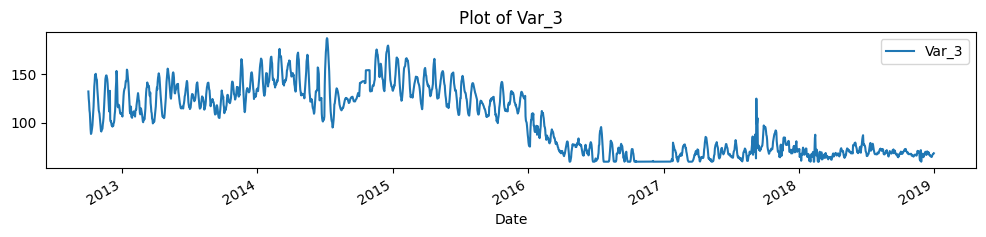

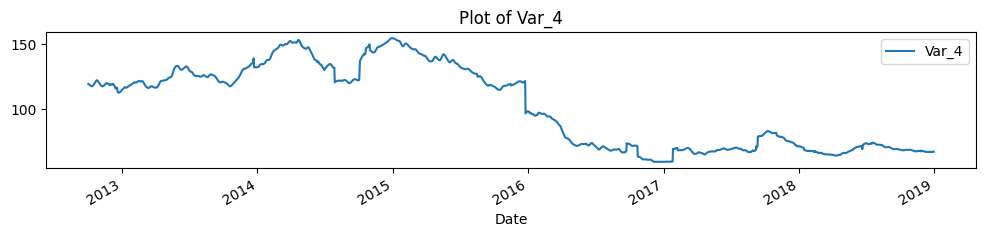

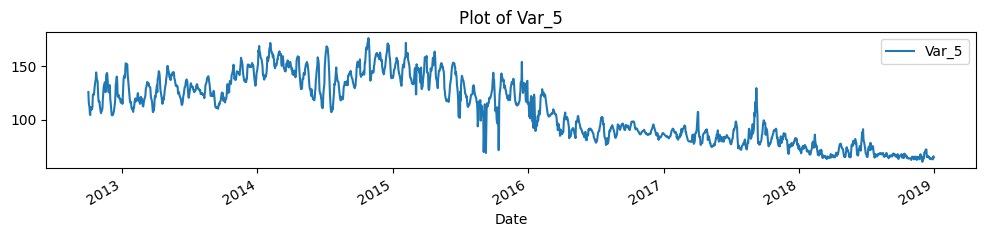

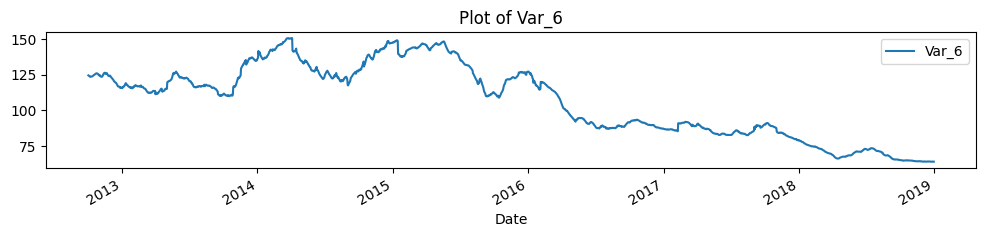

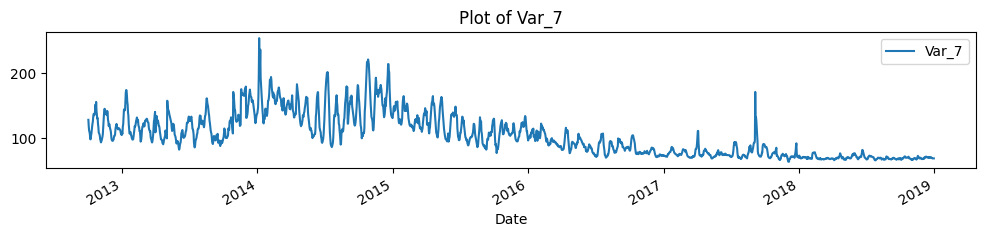

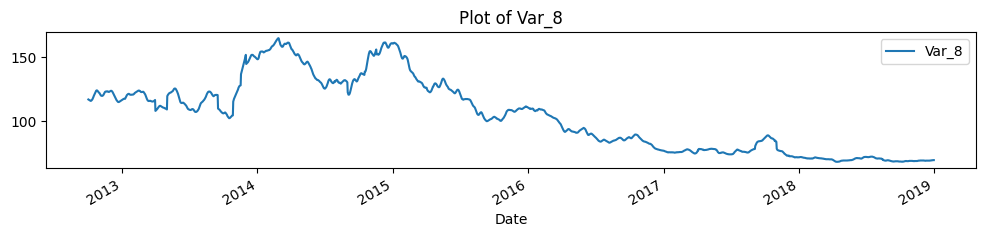

In [554]:
for i in range(1, 9):
    df.plot(x='Date', y=f'Var_{i}', figsize=(12, 2))
    plt.title(f'Plot of Var_{i}')
    plt.show()

Now we import our data to compare the two datasets, identify which variable corresponds to which, and determine if they are identical.

In [555]:
df_original = pd.read_pickle('./preprocessed_data/dataframes/solfsmy.pkl')

data_columns = ['JulianDay', 'F10', 'S10', 'M10', 'Y10', 'Date']

df_original = df_original[(df_original.Date >= config.test_start_datetime) & (df_original.Date < config.test_end_datetime)][data_columns]
df_original.head(1)

,JulianDay,F10,S10,M10,Y10,Date
5752,2456202.0,128.100006,139.800003,130.399994,126.400002,2012-10-01 12:00:00


In [556]:
head_original = df_original[['F10', 'M10', 'S10', 'Y10', 'Date']].head(10)
head_df = df[['Var_1', 'Var_2', 'Var_3', 'Var_4','Var_5', 'Var_6', 'Var_7', 'Var_8', 'Date']].head(10)

pd.merge(head_original, head_df, on='Date', suffixes=('_original', '_df'))

,F10,M10,S10,Y10,Date,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8
0,128.100006,130.399994,139.800003,126.400002,2012-10-01 12:00:00,113.199997,103.500000,131.899994,119.300003,125.900002,124.400002,128.100006,116.900002
1,118.199997,123.099998,130.500000,117.599998,2012-10-02 12:00:00,108.000000,103.400002,124.500000,119.199997,117.000000,124.199997,118.199997,116.699997
2,111.699997,118.900002,123.099998,114.099998,2012-10-03 12:00:00,102.900002,103.300003,120.199997,119.000000,113.400002,124.099998,111.699997,116.400002
3,109.500000,111.500000,111.099998,112.900002,2012-10-04 12:00:00,98.500000,103.199997,112.699997,118.699997,111.900002,123.900002,109.500000,116.199997
4,106.199997,110.900002,113.000000,107.300003,2012-10-05 12:00:00,95.500000,103.000000,109.599998,118.400002,106.099998,123.599998,106.199997,116.099998
5,98.800003,107.599998,102.300003,105.699997,2012-10-06 12:00:00,92.599998,103.000000,101.500000,118.199997,104.300003,123.400002,98.800003,115.900002
6,98.099998,92.500000,98.900002,114.099998,2012-10-07 12:00:00,90.199997,103.000000,93.400002,117.900002,111.699997,123.500000,98.099998,115.800003
7,103.400002,87.599998,104.300003,113.400002,2012-10-08 12:00:00,89.900002,103.199997,88.400002,117.699997,110.800003,123.500000,103.400002,115.800003
8,106.199997,88.400002,107.099998,111.699997,2012-10-09 12:00:00,91.599998,103.400002,89.199997,117.599998,109.000000,123.599998,106.199997,116.000000
9,112.000000,90.699997,111.699997,114.500000,2012-10-10 12:00:00,95.800003,103.699997,91.599998,117.599998,111.400002,123.599998,112.000000,116.300003


The variables 2, 4, 6, and 8 appear to be rolling means of the actual values represented by variables 1, 3, 5, and 7. Additionally, after comparing our values with these variables, it seems that the correspondence between this dataset and ours is as follows:

- **Var_1** → **S10**
- **Var_3** → **Y10**
- **Var_5** → **M10**
- **Var_7** → **F10**

Therefore, we will select and rename the variables accordingly.


In [557]:
df.drop(columns=['Var_2', 'Var_4', 'Var_6', 'Var_8'], inplace=True)
df.rename({'Var_1': 'S10', 'Var_3': 'Y10', 'Var_5': 'M10', 'Var_7': 'F10'}, axis=1, inplace=True)
df.tail()

,JulianDay,S10,Y10,M10,F10,Date
2307,2458480.0,52.500000,66.800003,63.500000,69.0,2018-12-27 12:00:00
2308,2458481.0,52.500000,67.500000,62.400002,69.0,2018-12-28 12:00:00
2309,2458482.0,52.599998,68.000000,64.800003,69.0,2018-12-29 12:00:00
2310,2458483.0,52.599998,68.000000,65.400002,69.0,2018-12-30 12:00:00
2311,2458484.0,52.799999,68.599998,64.300003,69.0,2018-12-31 12:00:00


And now we are going to check how both dataframes are related:

In [558]:
thresholds = {
    'F10':  [(0,75), (76,150), (151,190), (191, np.inf)],
    'S10': [(0,65), (66,150), (151,215), (216, np.inf)],
    'M10': [(0,72), (73,144), (145,167), (168, np.inf)],
    'Y10': [(0,81), (82,148), (149,165), (166, np.inf)]
}

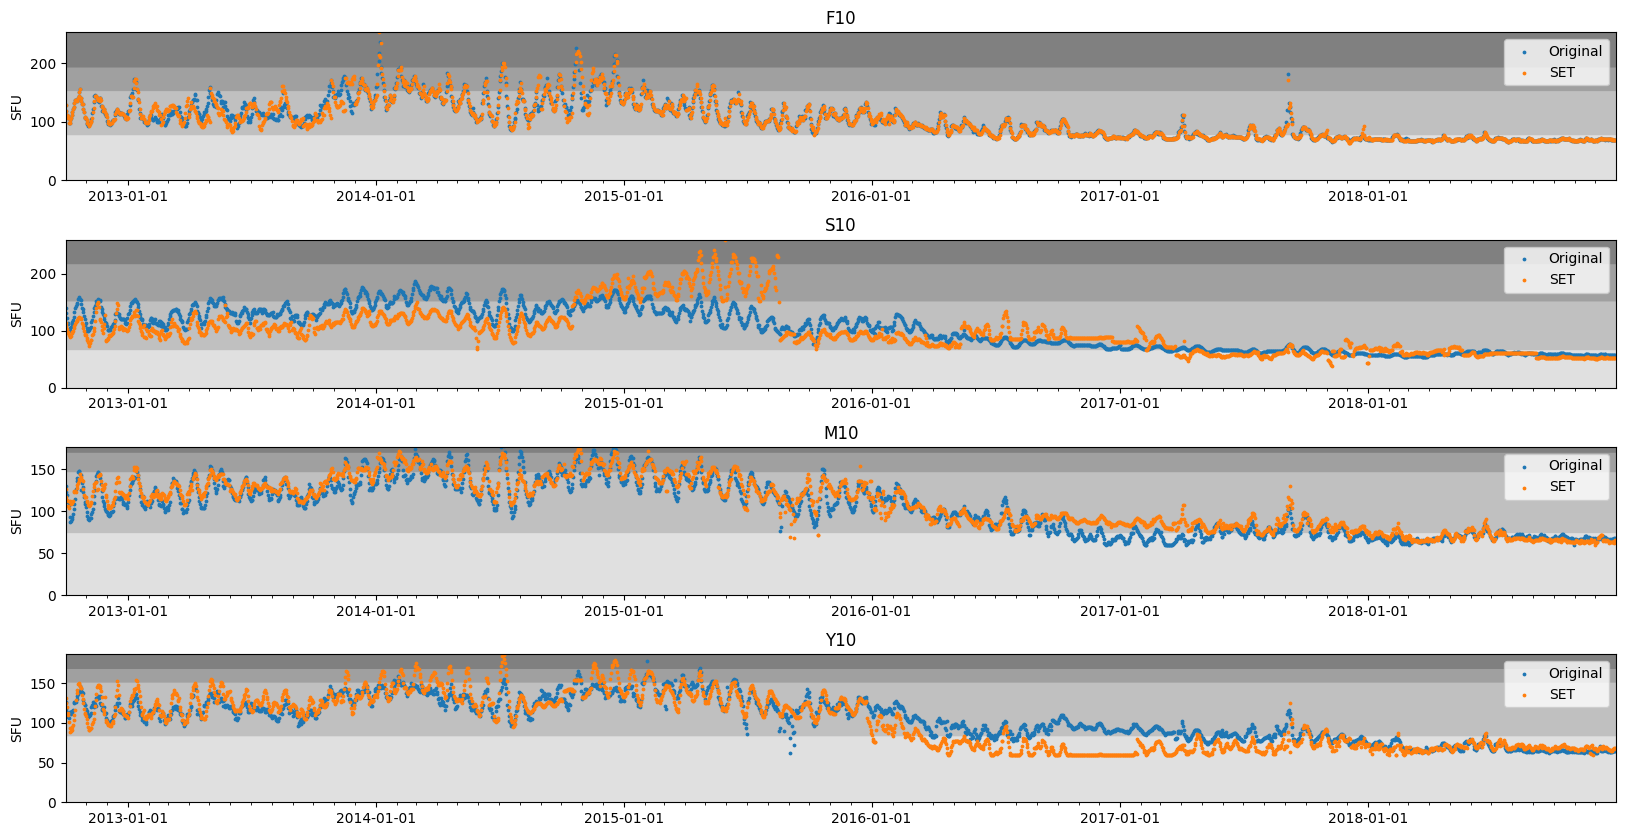

In [559]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10))

plt.subplots_adjust(hspace=0.4)

for i, var in enumerate(['F10', 'S10', 'M10', 'Y10']):
    ax[i].scatter(df_original.Date, df_original[var], label='Original', s=3)
    ax[i].scatter(df.Date, df[var],
               label='SET', s=3)
    ax[i].set_title(var)
    ax[i].set_ylabel('SFU')  # Add y-axis label with SFU
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator()) # set x-axis ticks to be yearly
    
    set_ranges = np.zeros((int(df[var].max()), df.shape[0], 4)) # (Height, Width)

    for j, (start, end) in enumerate(thresholds[var]):
        set_ranges[int(start):, :, :] = [0, 0, 0, ((j + 1) / 4)]
   
    ax[i].imshow(set_ranges, extent=[df.Date.min(), df.Date.max(), 0, df[var].max()], aspect='auto', alpha=0.5, origin='lower')

As we can see, our data differs from the SET data. Since we only have their data from 2012 to 2018, we will use our data to train the model. However, for the classification of results, we will use their data (at least for S10.7, which shows the most significant differences from our values).

In [560]:
# Save SET data to classify the test data on evaluation
df.index = df_original.index

df.to_pickle('./preprocessed_data/dataframes/set_solfsmy.pkl')